# Pr8-2: 背景差分

## 必要なライブラリのインストール

In [1]:
# プログレスバー用ライブラリのインストール
! pip install fastprogress
from fastprogress import progress_bar

# 動画入出力に使うライブラリ
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Colab上での出力用ライブラリ
from IPython.display import HTML
import base64
import io

## 表示・入出力用の補助関数

In [2]:
def display_video(video_file):
  cap = cv2.VideoCapture(video_file)
  w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  cap.release()
  video = io.open(video_file, 'r+b').read()
  encoded = base64.b64encode(video)
  html_code = '''<video width="70%" height="70%" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
 
  return(HTML(data=html_code.format(encoded.decode('ascii'))))

## OpenCVの背景差分のひな形コード

今回の演習では，中身の詳細までは追わなくても良いです．
（実際にどうコードを書くか興味がある人は，覗いてみると良いです．）

```
# 背景差分オブジェクトの作成
bgs_obj = cv2.bgsegm.createBackgroundSubtractorMOG()

for i in progress_bar(range(num_frames)):
  # フレーム毎の背景差分処理
  A = bgs_obj.apply(I)
```

ひな形コードでは，フレーム毎にbgs_obj.apply(I)を呼び出すようになっていて，
cv2.bgsegm.createBackgroundSubtractorMOGの所を別の関数に置き換えることで色々なアルゴリズムを試せます．


In [3]:
def cv_bgs_common(in_file, out_file, codec, bgs_obj):
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
  cap = cv2.VideoCapture(in_file)

  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  num_frames = min(num_frames, 300)

  w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = cap.get(cv2.CAP_PROP_FPS)

  fourcc = cv2.VideoWriter_fourcc(*codec)
  writer = cv2.VideoWriter(out_file, fourcc, fps, (w, h))

  for i in progress_bar(range(num_frames)):
    ret, I = cap.read()

    if ret == False:
      break

    A = bgs_obj.apply(I)

    if kernel is not None:
      A = cv2.morphologyEx(A, cv2.MORPH_OPEN, kernel)

    I_t = np.float32(cv2.cvtColor(I, cv2.COLOR_BGR2RGB)) / 255.0
    A_rgb = np.float32(cv2.cvtColor(A, cv2.COLOR_GRAY2RGB)) / 255.0

    color_bg = np.array([0, 1, 0])

    # Alphaブレンディングで抽出結果を可視化
    I_fg_t = A_rgb * I_t + (1.0-A_rgb) * color_bg

    writer.write(np.uint8(255*cv2.cvtColor(np.float32(I_fg_t), cv2.COLOR_RGB2BGR)))

  cap.release()
  writer.release()


## Work: フレーム差分の実験

以下の手法を切り替えてみて，フレーム差分で前景画像を切り出す効果を確認してみましょう．



In [4]:
in_file = "visiontraffic.mp4" #@param {type: "string"}
bgs_method = "GSOC"  #@param ['MOG', 'MOG2', 'GMG', 'LSBP', 'GSOC', 'KNN', 'CNT']

out_file = "CV_BGS_{0}.webm".format(bgs_method)
codec = "vp80" 

if bgs_method == "MOG":
  bgs_obj = cv2.bgsegm.createBackgroundSubtractorMOG()
elif bgs_method == "MOG2":
  bgs_obj = cv2.bgsegm.createBackgroundSubtractorMOG2()
elif bgs_method == "GMG":
  bgs_obj = cv2.bgsegm.createBackgroundSubtractorGMG()
elif bgs_method == "LSBP":
  bgs_obj = cv2.bgsegm.createBackgroundSubtractorLSBP()
elif bgs_method == "GSOC":
  bgs_obj = cv2.bgsegm.createBackgroundSubtractorGSOC()
elif bgs_method == "KNN":
  bgs_obj = cv2.createBackgroundSubtractorKNN()
elif bgs_method == "CNT":
  bgs_obj = cv2.bgsegm.createBackgroundSubtractorCNT()

cv_bgs_common(in_file, out_file, codec, bgs_obj)

display_video(out_file)

## 基礎的な背景差分を実装してみましょう．

### 背景フレームと処理を行うフレームの確認

Text(0.5, 1.0, 'Frame: 152')

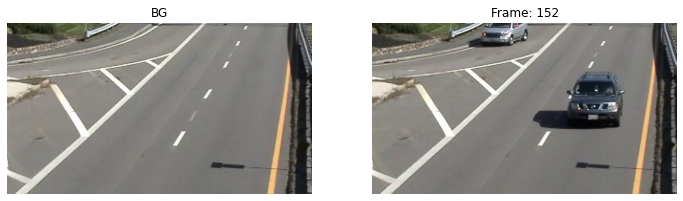

In [5]:
#@markdown 入力ファイル
in_file = "visiontraffic.mp4" #@param {type: "string"}
#@markdown 処理を行うフレームの時間
t = 152 #@param {type: "slider", min: 0, max: 1000, step:1}
#@markdown 背景フレームの時間
t_bg = 0 #@param {type: "slider", min: 0, max: 1000, step:1}

cap = cv2.VideoCapture(in_file)

num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# ターゲットフレームの読み込み
for i in progress_bar(range(num_frames)):
  ret, I_t = cap.read()

  if ret == False:
    break

  I_t = np.float32(cv2.cvtColor(I_t, cv2.COLOR_BGR2RGB)) / 255.0

  if i==t_bg:
    I_bg = np.array(I_t)

  if i==t:
    break

cap.release()

fig = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(I_bg)
plt.axis('off')
plt.title("BG")

plt.subplot(1, 2, 2)
plt.imshow(I_t)
plt.axis('off')
plt.title("Frame: {0}".format(t))

## Work: 背景差分の実装

$I_{bg}$と$I(t)$から背景差分$D$を計算してみましょう．

- $D = |I(t) - I_{bg} |$

Work:
1. I_tとI_bgをグレースケール画像に変換
2. Dの計算: |I_t_gray - I_bg_gray| 

ヒント

```
# グレースケール画像への変換
I_gray = cv2.cvt?(I, cv2.COLOR_?)

# 絶対値の計算
B = np.abs(A)
```

(-0.5, 639.5, 359.5, -0.5)

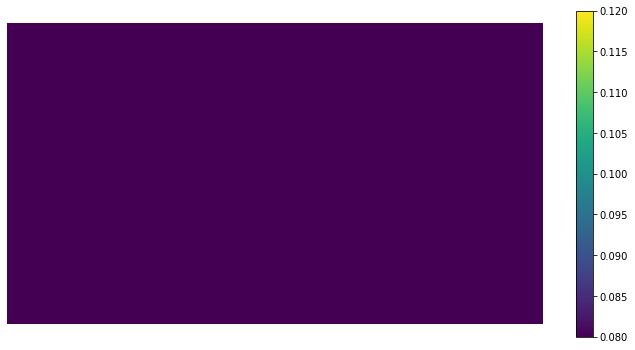

In [6]:
def frame_diff(I_t, I_bg):
  # Work: I_t_grayの計算
  I_t_gray =  np.zeros_like(I_t[:,:,0])

  # Work: I_bg_grayの計算
  I_bg_gray = np.zeros_like(I_bg[:,:,0])

  # Work: |I_t_gray - I_bg_gray|の計算
  D = np.zeros_like(I_bg[:,:,0])

  return D

D = frame_diff(I_t, I_bg)

vmin = 0.08 #@param {type: "slider", min: 0, max: 1.0, step:0.01}
vmax = 0.12 #@param {type: "slider", min: 0, max: 1.0, step:0.01}

plt.figure(figsize=(12, 6))
plt.imshow(D, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.axis('off')

## 実装した結果で背景差分を適用

(-0.5, 639.5, 359.5, -0.5)

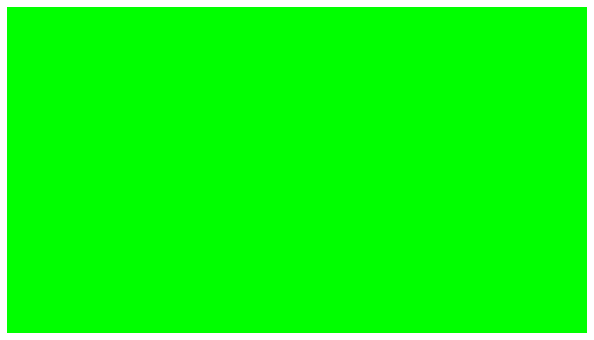

In [7]:
# 上の可視化結果を[0, 1]の範囲に変換，RGB化
A = np.clip((D - vmin) / (vmax - vmin), 0, 1)
A_rgb = cv2.cvtColor(A, cv2.COLOR_GRAY2RGB)

color_bg = np.array([0, 1, 0])

# Alphaブレンディングで抽出結果を可視化
I_fg_t = A_rgb * I_t + (1.0-A_rgb) * color_bg

plt.figure(figsize=(12, 6))
ax = plt.subplot(1,1,1)
ax.set_facecolor([0, 1, 0])
plt.imshow(I_fg_t)
plt.axis('off')

## 実装した結果で動画に適用

In [8]:
out_file = "BGS.webm"
codec = "vp80"

cap = cv2.VideoCapture(in_file)

num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*codec)
writer = cv2.VideoWriter(out_file, fourcc, fps, (w, h))

for i in progress_bar(range(num_frames)):
  ret, I_t = cap.read()

  if ret == False:
    break

  I_t = np.float32(cv2.cvtColor(I_t, cv2.COLOR_BGR2RGB)) / 255.0

  D = frame_diff(I_t, I_bg)

  A = np.clip((D - vmin) / (vmax - vmin), 0, 1)
  A_rgb = cv2.cvtColor(A, cv2.COLOR_GRAY2RGB)

  color_bg = np.array([0, 1, 0])

  # Alphaブレンディングで抽出結果を可視化
  I_fg_t = A_rgb * I_t + (1.0-A_rgb) * color_bg

  writer.write(np.uint8(255*cv2.cvtColor(np.float32(I_fg_t), cv2.COLOR_RGB2BGR)))


cap.release()
writer.release()

display_video(out_file)